In [1]:
import os
import sys
import subprocess
import time
import logging
import json
from pathlib import Path
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
import cv2
import numpy as np
import pandas as pd
import torch
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# Define your dataset and extraction folder (adjust the paths as needed)
DATASET_ROOT = Path("C:/Users/abhis/Downloads/Documents/Learner Engagement Project/data/DAiSEE/DataSet").resolve()
FRAMES_ROOT  = Path("C:/Users/abhis/Downloads/Documents/Learner Engagement Project/data/DAiSEE/ExtractedFrames").resolve()

# Validate that the dataset contains the required splits.
def validate_dataset(directory: Path):
    required_folders = ["Train", "Validation", "Test"]
    for folder in required_folders:
        folder_path = directory / folder
        if not folder_path.exists():
            raise FileNotFoundError(f"Missing dataset split: {folder_path}")
    print(f"✅ Dataset validated at {directory}")

validate_dataset(DATASET_ROOT)

✅ Dataset validated at C:\Users\abhis\Downloads\Documents\Learner Engagement Project\data\DAiSEE\DataSet


### **Extract Frames from Videos**

Convert video files into individual frames for model training. This step is necessary as the DAiSEE dataset contains video clips, and models require image frames.


In [2]:
# Persistent storage file to remember which videos have been processed.
PROCESSED_VIDEOS_FILE = FRAMES_ROOT / "processed_videos.json"

def load_processed_videos():
    if PROCESSED_VIDEOS_FILE.exists():
        with open(PROCESSED_VIDEOS_FILE, "r") as f:
            processed = json.load(f)
    else:
        processed = {}  # e.g., {"Train": ["1100011015", ...], "Validation": [...], "Test": [...]}
    return processed

def save_processed_video(split, video_stem):
    processed = load_processed_videos()
    if split not in processed:
        processed[split] = []
    if video_stem not in processed[split]:
        processed[split].append(video_stem)
    with open(PROCESSED_VIDEOS_FILE, "w") as f:
        json.dump(processed, f)

# Configure logging to both console and file.
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.StreamHandler(),
        logging.FileHandler('frame_extraction.log')
    ]
)
logger = logging.getLogger(__name__)

# Extraction parameters and resume settings
TARGET_FRAMES = 15
TARGET_RESOLUTION = (224, 224)
# If True, consider a video processed even if its folder has at least PARTIAL_THRESHOLD frames.
RESUME_ON_PARTIAL = True  
PARTIAL_THRESHOLD = 1  

# Build a dictionary of already existing output directories.
def get_existing_output_dirs(output_root: Path):
    processed = {}
    for split in ["Train", "Validation", "Test"]:
        split_dir = output_root / split
        if split_dir.exists():
            for video_dir in split_dir.iterdir():
                if video_dir.is_dir():
                    processed[(split, video_dir.name)] = video_dir
    return processed

# Scan the extraction folder and log how many videos are fully processed.
def verify_extracted_frames():
    processed_dirs = get_existing_output_dirs(FRAMES_ROOT)
    total_videos = 0
    fully_processed = 0
    for key, video_dir in processed_dirs.items():
        frames = list(video_dir.rglob("frame_*.jpg"))
        if frames:
            total_videos += 1
            if len(frames) >= TARGET_FRAMES:
                fully_processed += 1
    logger.info(f"Verification complete: {fully_processed}/{total_videos} videos fully processed")
    return fully_processed, total_videos

# Check for FFmpeg installation and CUDA support.
def check_ffmpeg():
    try:
        subprocess.run(['ffmpeg', '-version'], capture_output=True, text=True, check=True)
        cuda = subprocess.run(['ffmpeg', '-hwaccels'], capture_output=True, text=True, check=True)
        has_cuda = 'cuda' in cuda.stdout.lower()
        return True, has_cuda
    except (FileNotFoundError, subprocess.CalledProcessError):
        return False, False

# Compare dataset .avi files against the persistent record and output folder.
def get_unprocessed_videos(dataset_root: Path, output_root: Path):
    videos_to_process = []
    total_videos = 0
    already_processed_count = 0
    processed_dirs = get_existing_output_dirs(output_root)
    persistent = load_processed_videos()

    logger.info(f"Scanning dataset in: {dataset_root}")
    logger.info(f"Using extracted frames from: {output_root}")

    for video_path in dataset_root.rglob("*.avi"):
        total_videos += 1
        rel = video_path.relative_to(dataset_root)  # e.g., "Train/1100011015.avi"
        split = rel.parts[0]
        video_stem = video_path.stem

        # Check the persistent record first.
        if split in persistent and video_stem in persistent[split]:
            output_dir = output_root / split / video_stem
            if output_dir.exists():
                frames = list(output_dir.rglob("frame_*.jpg"))
                if len(frames) >= PARTIAL_THRESHOLD:
                    already_processed_count += 1
                    continue

        # Next, if the folder exists, use its frame count.
        output_dir = output_root / split / video_stem
        if output_dir.exists():
            frames = list(output_dir.rglob("frame_*.jpg"))
            if RESUME_ON_PARTIAL and len(frames) >= PARTIAL_THRESHOLD:
                already_processed_count += 1
                save_processed_video(split, video_stem)
                continue
            elif len(frames) >= TARGET_FRAMES:
                already_processed_count += 1
                save_processed_video(split, video_stem)
                continue
            else:
                # Remove incomplete frames.
                for frame in frames:
                    frame.unlink()

        videos_to_process.append((video_path, output_dir))
    
    logger.info("\nScan Results:")
    logger.info(f"Total .avi files found: {total_videos}")
    logger.info(f"Already processed (or partially processed): {already_processed_count}")
    logger.info(f"Remaining to process: {len(videos_to_process)}")
    return videos_to_process

# Extract frames from a single video using FFmpeg (with a fallback from GPU to CPU).
def extract_frames_with_ffmpeg(video_path, output_folder, use_gpu=True):
    try:
        output_folder = Path(output_folder)
        output_folder.mkdir(parents=True, exist_ok=True)

        # Get the video duration via ffprobe.
        duration_cmd = [
            'ffprobe', '-v', 'error',
            '-select_streams', 'v:0',
            '-show_entries', 'stream=duration',
            '-of', 'default=noprint_wrappers=1:nokey=1',
            str(video_path)
        ]
        duration_output = subprocess.check_output(duration_cmd, stderr=subprocess.STDOUT)
        duration = float(duration_output.decode().strip())
        frame_interval = max(1, duration / TARGET_FRAMES)

        cmd = ['ffmpeg', '-y']
        if use_gpu:
            cmd.extend([
                '-hwaccel', 'cuda',
                '-hwaccel_output_format', 'cuda',
                '-c:v', 'h264_cuvid'
            ])
        
        cmd.extend([
            '-i', str(video_path),
            '-vf', f'fps=1/{frame_interval},scale={TARGET_RESOLUTION[0]}:{TARGET_RESOLUTION[1]}',
            '-frame_pts', '1',
            '-vsync', '0',
            '-preset', 'ultrafast',
            '-q:v', '2',
            str(output_folder / 'frame_%04d.jpg')
        ])

        result = subprocess.run(cmd, capture_output=True, text=True)
        if result.returncode != 0:
            if use_gpu:
                # Retry with CPU if GPU fails.
                return extract_frames_with_ffmpeg(video_path, output_folder, use_gpu=False)
            raise subprocess.CalledProcessError(result.returncode, cmd, result.stderr)

        extracted_frames = list(output_folder.rglob("frame_*.jpg"))
        if not RESUME_ON_PARTIAL and len(extracted_frames) < TARGET_FRAMES:
            raise ValueError(f"Expected {TARGET_FRAMES} frames, got {len(extracted_frames)}")
        
        # Mark the video as processed.
        rel = video_path.relative_to(DATASET_ROOT)
        split = rel.parts[0]
        video_stem = video_path.stem
        save_processed_video(split, video_stem)

        return True, None

    except Exception as e:
        return False, str(e)

# Process all unprocessed videos using parallel workers.
def process_dataset(dataset_root: Path, output_root: Path, max_workers=None):
    if max_workers is None:
        max_workers = min(32, (os.cpu_count() or 1) + 4)
    
    video_paths = get_unprocessed_videos(dataset_root, output_root)
    if not video_paths:
        logger.info("No videos to process!")
        return 0, 0

    ffmpeg_available, cuda_available = check_ffmpeg()
    if not ffmpeg_available:
        raise RuntimeError("FFmpeg not found or not in PATH.")
    
    logger.info(f"Starting processing with {max_workers} workers (CUDA: {cuda_available})")
    failed_videos = []
    start_time = time.time()

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = {
            executor.submit(
                extract_frames_with_ffmpeg,
                str(vp[0]),  # video_path
                str(vp[1]),  # output_folder
                cuda_available
            ): vp[0] for vp in video_paths
        }
        with tqdm(total=len(video_paths), desc="Extracting frames") as pbar:
            for future in as_completed(futures):
                video_path = futures[future]
                try:
                    success, error = future.result()
                    if not success:
                        failed_videos.append((video_path, error))
                except Exception as e:
                    failed_videos.append((video_path, str(e)))
                pbar.update(1)

    elapsed_time = time.time() - start_time
    success_count = len(video_paths) - len(failed_videos)
    logger.info(f"\nProcessing completed in {elapsed_time:.2f} seconds")
    logger.info(f"Successfully processed: {success_count}/{len(video_paths)} videos")
    if failed_videos:
        logger.error(f"\nFailed to process {len(failed_videos)} videos:")
        for video, error in failed_videos[:10]:
            logger.error(f"- {video.name}: {error}")
        if len(failed_videos) > 10:
            logger.error(f"... and {len(failed_videos) - 10} more")
    return success_count, len(failed_videos)

### **Process Entire Dataset**


In [3]:
if __name__ == "__main__":
    try:
        logger.info("Starting frame extraction process...")
        processed, total = verify_extracted_frames()
        logger.info(f"Found {processed} already processed video(s) out of {total} in the extracted frames folder.")
        
        # Run the extraction process.
        success, failures = process_dataset(DATASET_ROOT, FRAMES_ROOT)
        if failures:
            logger.error(f"Processing encountered errors with {failures} videos.")
        else:
            logger.info("All videos processed successfully!")
        
        # Best Practice:
        # For long-running tasks, consider running this script as a scheduled task or as a background service 
        # (for example, via a cron job, Windows Task Scheduler, or nohup) so that it can run uninterrupted.
        
        sys.exit(0 if failures == 0 else 1)
    except Exception as e:
        logger.error(f"Fatal error: {str(e)}")
        sys.exit(1)


2025-02-09 16:55:36,615 - INFO - Starting frame extraction process...
2025-02-09 16:55:36,636 - INFO - Verification complete: 0/52 videos fully processed
2025-02-09 16:55:36,637 - INFO - Found 0 already processed video(s) out of 52 in the extracted frames folder.
2025-02-09 16:55:36,644 - INFO - Scanning dataset in: C:\Users\abhis\Downloads\Documents\Learner Engagement Project\data\DAiSEE\DataSet
2025-02-09 16:55:36,645 - INFO - Using extracted frames from: C:\Users\abhis\Downloads\Documents\Learner Engagement Project\data\DAiSEE\ExtractedFrames
2025-02-09 16:55:40,149 - INFO - 
Scan Results:
2025-02-09 16:55:40,150 - INFO - Total .avi files found: 8231
2025-02-09 16:55:40,151 - INFO - Already processed (or partially processed): 52
2025-02-09 16:55:40,151 - INFO - Remaining to process: 8179
2025-02-09 16:55:40,257 - INFO - Starting processing with 20 workers (CUDA: True)
Extracting frames: 100%|██████████| 8179/8179 [19:16<00:00,  7.08it/s]
2025-02-09 17:14:56,655 - INFO - 
Processing 

SystemExit: 1

c:\Users\abhis\Downloads\Documents\Learner Engagement Project\venv\Lib\site-packages\IPython\core\interactiveshell.py:3587: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


### **Data Transforms**

Define transformations for training (with data augmentation) and validation/testing (without augmentation).


In [3]:
from torchvision import transforms

# Preprocessing transformations for training and validation
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

valid_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])


### **Custom Dataset Class**

Create a custom dataset loader to read image paths and labels from text files.


In [6]:
import os
import torch
from torch.utils.data import Dataset
import pandas as pd
from pathlib import Path
from PIL import Image
import logging
from tqdm import tqdm
from torchvision.io import read_image
from torchvision.transforms.functional import to_pil_image

# Ensure the logger shows DEBUG messages
logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)

class DAiSEEDataset(Dataset):
    """
    Updated dataset class for DAiSEE that reads a CSV with four engagement metrics.
    It precomputes the frame paths based on the ClipID and loads labels for 
    Boredom, Engagement, Confusion, and Frustration.
    
    If the ClipID does not contain a slash (i.e. it's just a number), the split is
    inferred from the CSV file name. For example, for TrainLabels.csv, we assume the split is "Train".
    """
    def __init__(self, root, csv_path, transform=None, use_cache=True):
        self.root = Path(root)
        self.transform = transform
        self.use_cache = use_cache
        
        # Read the CSV file
        self.data = pd.read_csv(csv_path)
        
        # Pre-compute frame paths and labels with a progress bar
        self.frame_paths = []
        self.labels = []
        
        logger.info(f"Processing {len(self.data)} entries from {csv_path.name}")
        for idx, row in tqdm(self.data.iterrows(), total=len(self.data), desc="Loading dataset"):
            try:
                clip_id = str(row['ClipID']).strip()
                # Remove the .avi extension if present
                if '.avi' in clip_id:
                    clip_id = clip_id.replace('.avi', '')
                parts = clip_id.split('/')
                
                # Determine the frame path based on the number of parts:
                if len(parts) == 1:
                    # If only one part exists, infer the split from the CSV filename.
                    # For example, if csv_path is TrainLabels.csv, we deduce split = "Train".
                    split_guess = csv_path.stem.replace("Labels", "").strip()
                    frame_path = self.root / split_guess / parts[0] / "frame_0001.jpg"
                elif len(parts) == 2:
                    frame_path = self.root / parts[0] / parts[1] / "frame_0001.jpg"
                elif len(parts) >= 3:
                    frame_path = self.root / parts[0] / parts[1] / parts[2] / "frame_0001.jpg"
                else:
                    logger.debug(f"Skipping row {idx}: unexpected ClipID format: {clip_id}")
                    continue  # Skip rows that do not match the expected pattern

                # Log the computed frame path
                if not frame_path.exists():
                    logger.debug(f"Frame path does not exist: {frame_path}")
                else:
                    logger.debug(f"Found frame: {frame_path}")
                
                if frame_path.exists():
                    self.frame_paths.append(frame_path)
                    self.labels.append([
                        float(row['Boredom']),
                        float(row['Engagement']),
                        float(row['Confusion']),
                        float(str(row['Frustration ']).strip())
                    ])
            except Exception as e:
                logger.debug(f"Skipping row {idx} due to error: {e}")
                continue
        
        logger.info(f"Loaded {len(self.frame_paths)} valid frames")
        
        if len(self.frame_paths) == 0:
            raise ValueError(f"No valid frames found in {csv_path}")
    
    def __len__(self):
        return len(self.frame_paths)
    
    def __getitem__(self, idx):
        img_path = self.frame_paths[idx]
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        # Use torchvision.io.read_image which returns a tensor of shape [C, H, W]
        img_tensor = read_image(img_path)
        # Optionally convert the tensor to a PIL image if your transform chain requires it
        if self.transform:
            img = self.transform(to_pil_image(img_tensor))
        else:
            img = img_tensor
        return img, label


###  **Load Labels and Create DataLoaders**

Generate new labels files pointing to extracted frames and set up PyTorch DataLoaders.


In [7]:
def generate_labels_files(csv_path, new_labels_path, frames_root):
    """Generate labels files with all four engagement metrics."""
    try:
        if not csv_path.exists():
            logger.error(f"Labels CSV not found: {csv_path}")
            return False
            
        df = pd.read_csv(csv_path)
        logger.info(f"Processing {len(df)} rows from {csv_path.name}")
        
        new_labels = []
        for idx, row in df.iterrows():
            try:
                # Get all labels – ensure that any extra whitespace is removed from 'Frustration '
                labels = [
                    str(row['Boredom']),
                    str(row['Engagement']),
                    str(row['Confusion']),
                    str(row['Frustration ']).strip()
                ]
                
                video_path = row['ClipID']
                # Normalize the path separator and split
                path_parts = video_path.replace('\\', '/').split('/')
                # New logic: if exactly 2 parts then use them; if 3 or more, use the first three.
                if len(path_parts) == 2:
                    frame_path = Path(frames_root) / path_parts[0] / path_parts[1] / "frame_0001.jpg"
                elif len(path_parts) >= 3:
                    frame_path = Path(frames_root) / path_parts[0] / path_parts[1] / path_parts[2] / "frame_0001.jpg"
                else:
                    continue
                
                if frame_path.exists():
                    label_line = f"{frame_path} {' '.join(labels)}\n"
                    new_labels.append(label_line)
                    if idx % 1000 == 0:
                        logger.info(f"Processed {idx} rows...")
                else:
                    logger.debug(f"Frame not found: {frame_path}")
                    
            except Exception as e:
                logger.error(f"Error processing row {idx}: {row['ClipID']}")
                logger.error(f"Error details: {str(e)}")
                continue
        
        if new_labels:
            os.makedirs(os.path.dirname(new_labels_path), exist_ok=True)
            with open(new_labels_path, 'w') as f:
                f.writelines(new_labels)
            logger.info(f"Created labels file with {len(new_labels)} entries: {new_labels_path}")
            if new_labels:
                logger.info(f"Sample label line: {new_labels[0]}")
            return True
        else:
            logger.error(f"No valid labels found in {csv_path}")
            return False
            
    except Exception as e:
        logger.error(f"Failed to process {csv_path}")
        logger.error(f"Error: {str(e)}")
        return False


In [8]:
import os
import torch
from pathlib import Path
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
import logging
from tqdm import tqdm

# Configure logging (if not already configured)
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

# Define paths (adjust as needed)
DATASET_ROOT = Path("C:/Users/abhis/Downloads/Documents/Learner Engagement Project/data/DAiSEE/DataSet")
FRAMES_ROOT = Path("C:/Users/abhis/Downloads/Documents/Learner Engagement Project/data/DAiSEE/ExtractedFrames")

# (Assuming the updated DAiSEEDataset class from Cell 5 is already defined or imported)

# Define optimized transforms (you can reuse those from cell 4)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logger.info(f"Using device: {device}")

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

valid_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Function to test loader speed (for performance tuning)
def test_loader_speed(loader, num_batches=5):
    import time
    times = []
    for i, (images, labels) in enumerate(loader):
        if i == 0:
            start = time.time()
        elif i <= num_batches:
            times.append(time.time() - start)
            start = time.time()
        else:
            break
    return sum(times) / len(times) if times else 0

try:
    # Create datasets for each split using the updated DAiSEEDataset
    datasets = {}
    for split_name, transform, csv_name in [
        ("Train", train_transform, "TrainLabels.csv"),
        ("Validation", valid_transform, "ValidationLabels.csv"),
        ("Test", valid_transform, "TestLabels.csv")
    ]:
        csv_path = DATASET_ROOT / "Labels" / csv_name
        datasets[split_name] = DAiSEEDataset(
            root=FRAMES_ROOT,
            csv_path=csv_path,
            transform=transform
        )
    
    # Optimize loader settings: set NUM_WORKERS to 0 to avoid multiprocessing issues on Windows.
    BATCH_SIZE = 32
    NUM_WORKERS = 0  # Use the main thread for loading

    # Create DataLoaders for each split without persistent_workers.
    loaders = {
        "Train": DataLoader(
            datasets["Train"],
            batch_size=BATCH_SIZE,
            shuffle=True,
            num_workers=NUM_WORKERS,
            pin_memory=True
        ),
        "Validation": DataLoader(
            datasets["Validation"],
            batch_size=BATCH_SIZE,
            num_workers=NUM_WORKERS,
            pin_memory=True
        ),
        "Test": DataLoader(
            datasets["Test"],
            batch_size=BATCH_SIZE,
            num_workers=NUM_WORKERS,
            pin_memory=True
        )
    }
    
    logger.info("Testing loader speeds...")
    for name, loader in loaders.items():
        speed = test_loader_speed(loader)
        logger.info(f"{name} loader: {speed:.3f} seconds per batch")

except Exception as e:
    logger.error(f"Setup failed: {e}")
    raise


2025-02-09 17:46:26,211 - INFO - Using device: cpu
2025-02-09 17:46:26,219 - INFO - Processing 5358 entries from TrainLabels.csv
Loading dataset:   0%|          | 0/5358 [00:00<?, ?it/s]2025-02-09 17:46:26,224 - DEBUG - Found frame: C:\Users\abhis\Downloads\Documents\Learner Engagement Project\data\DAiSEE\ExtractedFrames\Train\1100011002\frame_0001.jpg
2025-02-09 17:46:26,225 - DEBUG - Found frame: C:\Users\abhis\Downloads\Documents\Learner Engagement Project\data\DAiSEE\ExtractedFrames\Train\1100011003\frame_0001.jpg
2025-02-09 17:46:26,226 - DEBUG - Found frame: C:\Users\abhis\Downloads\Documents\Learner Engagement Project\data\DAiSEE\ExtractedFrames\Train\1100011004\frame_0001.jpg
2025-02-09 17:46:26,227 - DEBUG - Found frame: C:\Users\abhis\Downloads\Documents\Learner Engagement Project\data\DAiSEE\ExtractedFrames\Train\1100011005\frame_0001.jpg
2025-02-09 17:46:26,228 - DEBUG - Found frame: C:\Users\abhis\Downloads\Documents\Learner Engagement Project\data\DAiSEE\ExtractedFrames\T

### **Visualize Sample Data**

Check preprocessing by visualizing a batch of images with their labels.


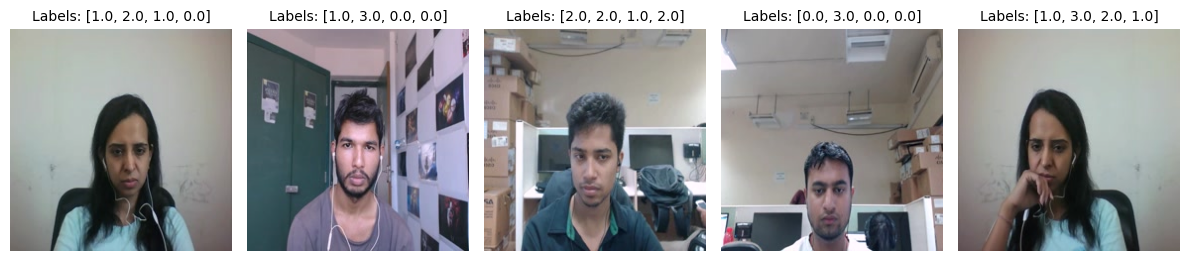

In [12]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

def display_samples(data_loader, n_samples=5):
    """Display a grid of sample images with engagement labels."""
    try:
        images, labels = next(iter(data_loader))  # Get a batch
    except StopIteration:
        print("No data to display.")
        return
    
    # Inverse Transform to Convert Images Back to Displayable Format
    inv_trans = transforms.Compose([
        transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
                             std=[1/0.229, 1/0.224, 1/0.225]),
    ])
    
    plt.figure(figsize=(12, 4))
    for i in range(min(n_samples, len(images))):
        img = inv_trans(images[i])  # Reverse normalization
        img = img.permute(1, 2, 0).clamp(0, 1)  # Convert [C, H, W] → [H, W, C]
        
        plt.subplot(1, n_samples, i + 1)
        plt.imshow(img.numpy())  # Convert to NumPy format for Matplotlib
        plt.title(f"Labels: {labels[i].tolist()}", fontsize=10)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Display sample images from the training set using the "Train" loader from Cell 7
display_samples(loaders["Train"], n_samples=5)


### **Save preprocessed data**


In [15]:
import os
import torch

# Uncomment the lines below if you want to save the datasets for later use.
torch.save(datasets["Train"], os.path.join(str(FRAMES_ROOT), "train_set.pth"))
torch.save(datasets["Validation"], os.path.join(str(FRAMES_ROOT), "val_set.pth"))
torch.save(datasets["Test"], os.path.join(str(FRAMES_ROOT), "test_set.pth"))
